In [1]:
docker_compose_filename = "docker-compose-autogenerated.yaml"
num_of_clients = 1
controller_ip = "192.168.7.7"
delay = 2
straggler = False
dataset = "CIFAR10"
strategy = "FedAvg"
num_of_rounds = 3
central_eval = "false"
#     eval_clients: int = None
#     fit_clients: int = None
backend = "pytorch_mobilenetv2"#"pytorch_mobilenetv2"
# code_folder = "/home/moses/research/FDLC/container/code/"
code_folder = "/home/moses/back-up/research/FDLC/container/code/"

In [2]:
import numpy as np
from scipy.stats import dirichlet


def gaussian(N=1000, nodes=10, scale=1, **kwargs):
    x = np.linspace(0, nodes - 1, nodes)
    dist = np.exp(-np.abs(x) / 2 / scale ** 2)
    dist /= dist.sum()
    return N * dist


def pareto(N=1000, nodes=10, scale=1, shape=1, **kwargs):
    x = np.linspace(scale, scale + nodes - 1, nodes)
    dist = (shape * (scale ** shape)) / (x ** (shape + 1))
    dist /= dist.sum()
    return N * dist

def flat(N=1000,nodes=10, **kwargs):
    return np.linspace(N/nodes, N/nodes, nodes)

def dirichlet_func(N=100, nodes=10, random_state=None, **kwargs):
    alpha = np.ones(nodes)/nodes
    samples = dirichlet.rvs(alpha, size=1, random_state=random_state) * N
    res = list(samples.squeeze())
    res = [int(i) for i in res]
    res = [i if i>0 else 1 for i in res]
    res.sort(reverse=True)
    res = np.asarray(res)
    return res


_distributions = dict(
        gaussian=gaussian,
        pareto=pareto,
        flat=flat,
        dirichlet=dirichlet_func
    )

In [3]:
from generator import DockerComposeGenerator
DockerComposeGenerator(docker_compose_filename=docker_compose_filename, 
                       num_of_clients=num_of_clients, 
                       dataset=dataset,
                       backend=backend,
                       central_eval=central_eval,
                       strategy=strategy,
                       code_folder=code_folder,
                       num_of_rounds=num_of_rounds,
                       server_test_size=1000,
                       server_training_size = 5000,
                       train_size=50000,
                       test_size=10000,
                       dataset_distribution = 'flat',
                       dataset_distribution_parameters = '{"random_state":1}',
                       proxy = ""
                      ).generate_docker_compose()

compute_distribution = 'flat'

In [4]:
from FogifySDK import FogifySDK
docker_compose= "docker-compose-autogenerated.yaml"
controller_url= f"http://{controller_ip}:5000"
fogify = FogifySDK(controller_url, docker_compose)



In [5]:
num_of_cores = 8
init_num_of_cores = num_of_cores
freq = 1900
memory = 8
# 
# min_cores = 1
min_memory = 1

memory = memory - num_of_clients*min_memory
min_freq = 2400 / num_of_cores / num_of_clients 
freq -= min_freq

max_compute = num_of_cores*freq
distribution = _distributions[compute_distribution]
res = distribution(nodes = num_of_clients, N = max_compute)
print(res)
res += num_of_cores*min_freq
print(res)

CPU_res = res/num_of_cores
MEM_res = distribution(nodes = num_of_clients, N = memory)
MEM_res = MEM_res + min_memory

[12800.]
[15200.]


In [6]:
data_res = distribution(nodes = num_of_clients, N = 50000)


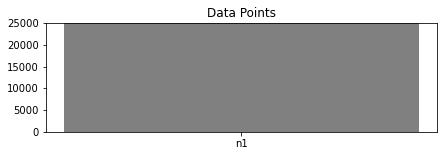

In [7]:
import numpy as np
import matplotlib.pyplot as plt

courses = ["n"+str(i+1) for i in range(num_of_clients)]
values = data_res
  
fig = plt.figure(figsize=(7,2))
plt.ylim((0, 25000))
# creating the bar plot
plt.bar(courses, values, color ='grey')
 
plt.title("Data Points")
plt.show()

In [8]:
fogify.add_node('typical', 2, 2400, "4G")
fogify.add_network("flnet", uplink=dict(bandwidth='100Mbps', latency=dict(delay=f'{delay}ms')),
                    downlink=dict(bandwidth='100Mbps', latency=dict(delay=f'{delay}ms')))
fogify.add_topology_node('server', 'server', 'typical', ["flnet"], 1)
for i in range(num_of_clients):
    fogify.add_node(f'client_{i}', num_of_cores, CPU_res[i], f"{MEM_res[i]}G")
    fogify.add_topology_node(f'client_{i}', f'client_{i}', f'client_{i}', ["flnet"], 1)
    print(f'client_{i}', num_of_cores, CPU_res[i], f"{MEM_res[i]}G")



client_0 8 1900.0 8.0G


In [9]:
44*2400

105600

In [10]:
fogify.deploy()

Deploy process: 100%|██████████| 2/2 [00:05<00:00,  2.53s/it]


{'message': "The services are deployed ( {'server': 1, 'client_0': 1} )"}

In [21]:
fogify.undeploy()

Undeploy process: 100%|██████████| 2/2 [00:25<00:00, 12.69s/it]


{'message': 'The 2 services are undeployed'}

In [11]:
fogify.get_metrics_from("server")

,network_rx_flnet,memory_util,disk_reads,timestamp,cpu,count,memory,disk_writes,network_tx_flnet
0,11343456.0,24.190235,0.0,1689493954292,26.585822,0,1.038963e+09,0.0,54898.0
1,11343456.0,24.190331,0.0,1689493959292,26.590510,1,1.038967e+09,0.0,54898.0
2,11343623.0,24.190331,0.0,1689493964292,26.593910,2,1.038967e+09,0.0,54898.0
3,11343818.0,24.190331,0.0,1689493969292,26.596554,3,1.038967e+09,0.0,54898.0
4,20493030.0,25.431633,0.0,1689493974292,26.771480,4,1.092280e+09,0.0,9203860.0
5,20493030.0,25.431633,0.0,1689493979292,26.776630,5,1.092280e+09,0.0,9203860.0
6,20493030.0,25.431633,0.0,1689493984292,26.781490,6,1.092280e+09,0.0,9203860.0


In [13]:
fogify.get_metrics_from("fogify_client_0")

,network_rx_flnet,memory_util,disk_reads,timestamp,cpu,count,memory,disk_writes,network_tx_flnet
0,6776.0,1.189184,0.0,1689493954292,5.729934,0,1.021501e+08,0.0,0.0
1,6776.0,3.093052,0.0,1689493959292,15.918924,1,2.656911e+08,0.0,0.0
2,33322.0,4.182196,0.0,1689493964292,26.976108,2,3.592479e+08,0.0,26309.0
3,11317815.0,4.587126,0.0,1689493969292,28.673298,3,3.940311e+08,0.0,11310677.0
4,20466819.0,13.146687,0.0,1689493974292,51.288356,4,1.129292e+09,0.0,20459597.0
5,20466819.0,13.155365,0.0,1689493979292,88.457676,5,1.130037e+09,0.0,20459597.0
6,20466819.0,13.199902,0.0,1689493984292,126.722442,6,1.133863e+09,0.0,20459597.0
7,20466819.0,13.199711,0.0,1689493989292,162.861892,7,1.133847e+09,0.0,20459597.0
8,20466819.0,13.199759,0.0,1689493994292,201.643036,8,1.133851e+09,0.0,20459597.0


<AxesSubplot:>

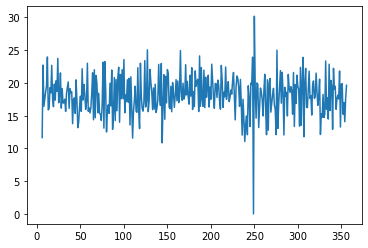

In [57]:
(fogify.get_metrics_from("fogify_client_0").cpu[5:].diff()).plot()

<AxesSubplot:>

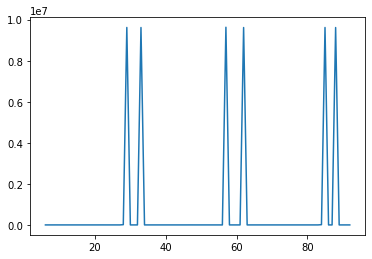

In [36]:
(fogify.get_metrics_from("fogify_client_0").network_tx_flnet[5:].diff()+fogify.get_metrics_from("fogify_client_0").network_rx_flnet.diff()).plot()

<AxesSubplot:>

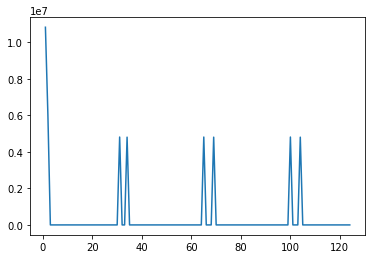

In [14]:
fogify.get_metrics_from("fogify_client_0").network_rx_flnet.diff().plot()

<AxesSubplot:>

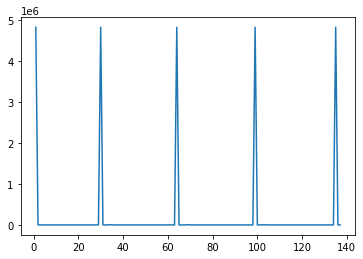

In [19]:
fogify.get_metrics_from("server").network_tx_flnet.diff().plot()

In [242]:
# fogify.get_metrics_from("fogify_server_1").to_csv(f"metrics/server-{dataset}-{backend}-{strategy}-{central_eval}.csv")
for i in range(num_of_clients):
    try:
        fogify.get_metrics_from(f"fogify_client_{i}").to_csv(f"metrics/client-{i}-{dataset}-{backend}-{strategy}-{central_eval}-{num_of_clients}-2023.csv")
    except Exception as ex:
        print(i, ex)
        continue


In [15]:
fogify.get_metrics_from(f"fogify_client_1")

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [12]:
fogify.get_metrics_from("server_1")

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [12]:
fogify.undeploy()

Undeploy process: 100%|██████████| 31/31 [00:36<00:00,  1.16s/it]


{'message': 'The 31 services are undeployed'}